<a href="https://colab.research.google.com/github/PosgradoMNA/actividades-del-projecto-equipo_37/blob/main/RETO/Subterraneas_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install geopandas qeds -q

In [ ]:
from google.colab import drive
import os

import pandas as pd
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import time
from collections import Counter

import geopandas as gpd
from shapely.geometry import Point

%matplotlib inline
# activate plot theme
import qeds
qeds.themes.mpl_style();

In [ ]:
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/Colab/Maestria/2022_Q4/01_TC4029.10_Ciencia_y_analítica_de_datos/Reto/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
zip_file_name = 'Datos_de_calidad_del_agua_de_5000_sitios_de_monitoreo.zip'

In [ ]:
import zipfile
with zipfile.ZipFile(data_path+zip_file_name, 'r') as zip_ref:
    zip_ref.extractall('')

In [ ]:
subterranea = '/content/Datos_de_calidad_del_agua_2020/Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_subterraneas_2020.csv'

#superficial = '/content/Datos_de_calidad_del_agua_2020/Datos_de_calidad_del_agua_de_sitios_de_monitoreo_de_aguas_superficiales_2020.csv'

In [ ]:
!head $subterranea

CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,ACUIFERO,SUBTIPO,LONGITUD,LATITUD,PERIODO,ALC_mg/L,CALIDAD_ALC,CONDUCT_mS/cm,CALIDAD_CONDUC,SDT_mg/L,SDT_M_mg/L,CALIDAD_SDT_ra,CALIDAD_SDT_salin,FLUORUROS_mg/L,CALIDAD_FLUO,DUR_mg/L,CALIDAD_DUR,COLI_FEC_NMP/100_mL,CALIDAD_COLI_FEC,N_NO3_mg/L,CALIDAD_N_NO3,AS_TOT_mg/L,CALIDAD_AS,CD_TOT_mg/L,CALIDAD_CD,CR_TOT_mg/L,CALIDAD_CR,HG_TOT_mg/L,CALIDAD_HG,PB_TOT_mg/L,CALIDAD_PB,MN_TOT_mg/L,CALIDAD_MN,FE_TOT_mg/L,CALIDAD_FE,SEMAFORO,CONTAMINANTES,CUMPLE_CON_ALC,CUMPLE_CON_COND,CUMPLE_CON_SDT_ra,CUMPLE_CON_SDT_salin,CUMPLE_CON_FLUO,CUMPLE_CON_DUR,CUMPLE_CON_CF,CUMPLE_CON_NO3,CUMPLE_CON_AS,CUMPLE_CON_CD,CUMPLE_CON_CR,CUMPLE_CON_HG,CUMPLE_CON_PB,CUMPLE_CON_MN,CUMPLE_CON_FE
DLAGU6,POZO SAN GIL,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,ASIENTOS,VALLE DE CHICALOTE,POZO,-102.022100,22.208870,2020,229.99,Alta,940,Permisible para riego,,603.6,Cultivos sensibles,Potable - Dulce,0.9766,Potable - Optima,213.732,Potable - Dura,<1.1,Potable - Excelente,4.184656,Pot

# Carga de datos

In [ ]:
df_sub = pd.read_csv(subterranea, encoding='cp1252')

for colum in list(df_sub.columns):
  
  try:
    df_sub[colum] = df_sub[colum].str.replace('<', '', regex=True) #Reemplazar valores con <
    df_sub[colum] = df_sub[colum].str.replace('=', '', regex=True) #Reemplazar valores con =

    try:
      df_sub[colum] = df_sub[colum].astype(float) #Convertir columas a flotantes
      
    except:
      pass

  except:
    pass

  df_sub[colum] = pd.to_numeric(df_sub[colum], errors='coerce').fillna(df_sub[colum]) #Convertir columas a Numericos

df_sub.head().T

,0,1,2,3,4
CLAVE,DLAGU6,DLAGU6516,DLAGU7,DLAGU9,DLBAJ107
SITIO,POZO SAN GIL,POZO R013 CAÑADA HONDA,POZO COSIO,POZO EL SALITRILLO,RANCHO EL TECOLOTE
ORGANISMO_DE_CUENCA,LERMA SANTIAGO PACIFICO,LERMA SANTIAGO PACIFICO,LERMA SANTIAGO PACIFICO,LERMA SANTIAGO PACIFICO,PENINSULA DE BAJA CALIFORNIA
ESTADO,AGUASCALIENTES,AGUASCALIENTES,AGUASCALIENTES,AGUASCALIENTES,BAJA CALIFORNIA SUR
MUNICIPIO,ASIENTOS,AGUASCALIENTES,COSIO,RINCON DE ROMOS,LA PAZ
ACUIFERO,VALLE DE CHICALOTE,VALLE DE CHICALOTE,VALLE DE AGUASCALIENTES,VALLE DE AGUASCALIENTES,TODOS SANTOS
SUBTIPO,POZO,POZO,POZO,POZO,POZO
LONGITUD,-102.0221,-102.20075,-102.28801,-102.29449,-110.2448
LATITUD,22.20887,21.99958,22.36685,22.18435,23.45138
PERIODO,2020,2020,2020,2020,2020


In [ ]:
df_sub.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CLAVE,1068,1068,DLAGU6,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SITIO,1068,1066,EL FUERTE,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ORGANISMO_DE_CUENCA,1068,13,CUENCAS CENTRALES DEL NORTE,232,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ESTADO,1068,32,DURANGO,121,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MUNICIPIO,1068,452,LA PAZ,27,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ACUIFERO,1068,273,PENINSULA DE YUCATAN,119,NaN,NaN,NaN,NaN,NaN,NaN,NaN
SUBTIPO,1068,8,POZO,1039,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LONGITUD,1068.0,NaN,NaN,NaN,-101.891007,6.703263,-116.66425,-105.388865,-102.17418,-98.974716,-86.86412
LATITUD,1068.0,NaN,NaN,NaN,23.163618,3.88767,14.56115,20.212055,22.61719,25.510285,32.677713
PERIODO,1068.0,NaN,NaN,NaN,2020.0,0.0,2020.0,2020.0,2020.0,2020.0,2020.0


## Balance de categorias

In [ ]:
#Lista de semaforo
df_sub['SEMAFORO'].unique().tolist()

['Verde', 'Rojo', 'Amarillo']

Conteo de datos deacuerdo a su etiqueta de semaforo

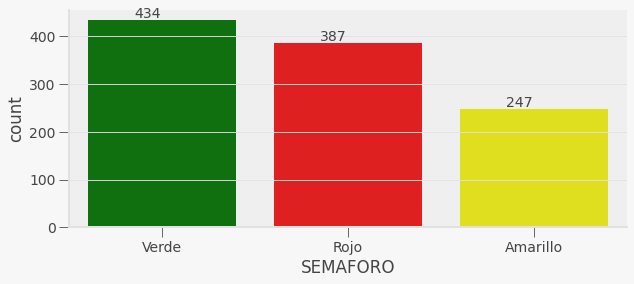

In [ ]:
color_list = ['green','red', 'yellow']

fig, ax = plt.subplots(figsize=(10,4))

ax = sns.countplot(data=df_sub, x='SEMAFORO',  palette=color_list)

for p in ax.patches:
  ax.annotate(p.get_height(), (p.get_x()+0.25,p.get_height()+5))

plt.show()


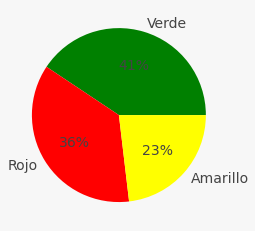

In [ ]:
semaforo = Counter(df_sub['SEMAFORO'])
colors_palete = sns.color_palette(color_list)

fig, ax = plt.subplots(figsize=(10,4))

plt.pie(semaforo.values(), labels=semaforo.keys(), colors=colors_palete, autopct='%.0f%%')

plt.show()

## Tipos de columnas

In [ ]:
df_sub.dtypes

CLAVE                    object
SITIO                    object
ORGANISMO_DE_CUENCA      object
ESTADO                   object
MUNICIPIO                object
ACUIFERO                 object
SUBTIPO                  object
LONGITUD                float64
LATITUD                 float64
PERIODO                   int64
ALC_mg/L                float64
CALIDAD_ALC              object
CONDUCT_mS/cm           float64
CALIDAD_CONDUC           object
SDT_mg/L                float64
SDT_M_mg/L              float64
CALIDAD_SDT_ra           object
CALIDAD_SDT_salin        object
FLUORUROS_mg/L          float64
CALIDAD_FLUO             object
DUR_mg/L                float64
CALIDAD_DUR              object
COLI_FEC_NMP/100_mL     float64
CALIDAD_COLI_FEC         object
N_NO3_mg/L              float64
CALIDAD_N_NO3            object
AS_TOT_mg/L             float64
CALIDAD_AS               object
CD_TOT_mg/L             float64
CALIDAD_CD               object
CR_TOT_mg/L             float64
CALIDAD_

In [ ]:
df_sub['ORGANISMO_DE_CUENCA'].unique()

array(['LERMA SANTIAGO PACIFICO', 'PENINSULA DE BAJA CALIFORNIA',
       'PENINSULA DE YUCATAN', 'RIO BRAVO', 'CUENCAS CENTRALES DEL NORTE',
       'PACIFICO NORTE', 'BALSAS', 'PACIFICO SUR', 'GOLFO NORTE',
       'AGUAS DEL VALLE DE MEXICO', 'GOLFO CENTRO', 'FRONTERA SUR',
       'NOROESTE'], dtype=object)

## Visualizacion de datos perdidos

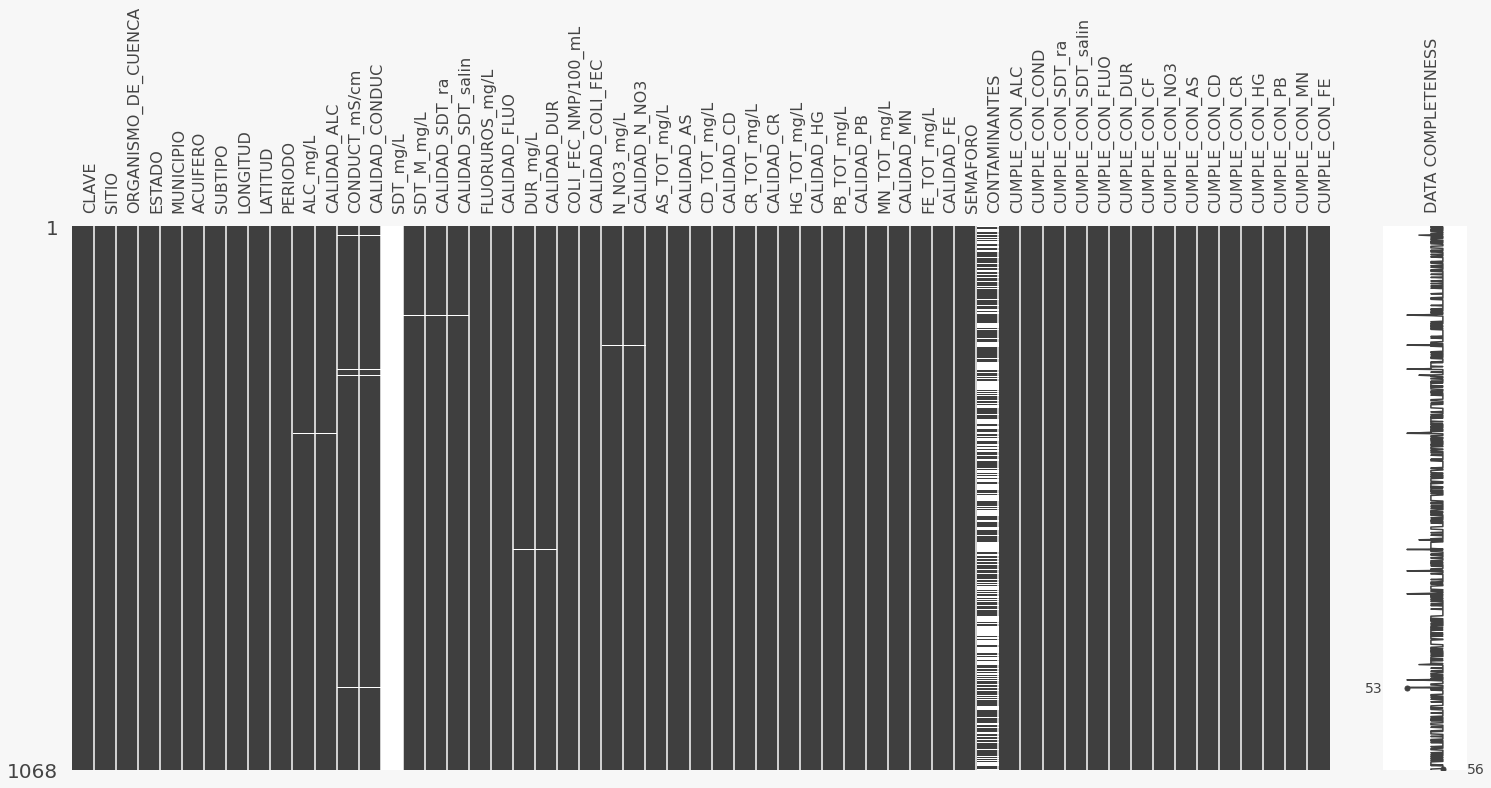

In [ ]:
msno.matrix(df_sub, labels=list(df_sub.columns),label_rotation=90)
plt.show()

## Seleccion de columnas numericas

In [ ]:
float_columns = [col for col in df_sub.columns if df_sub[col].dtypes != object]
print(len(float_columns), float_columns)

18 ['LONGITUD', 'LATITUD', 'PERIODO', 'ALC_mg/L', 'CONDUCT_mS/cm', 'SDT_mg/L', 'SDT_M_mg/L', 'FLUORUROS_mg/L', 'DUR_mg/L', 'COLI_FEC_NMP/100_mL', 'N_NO3_mg/L', 'AS_TOT_mg/L', 'CD_TOT_mg/L', 'CR_TOT_mg/L', 'HG_TOT_mg/L', 'PB_TOT_mg/L', 'MN_TOT_mg/L', 'FE_TOT_mg/L']


## Distribucion de datos contiuos

### Histogramas

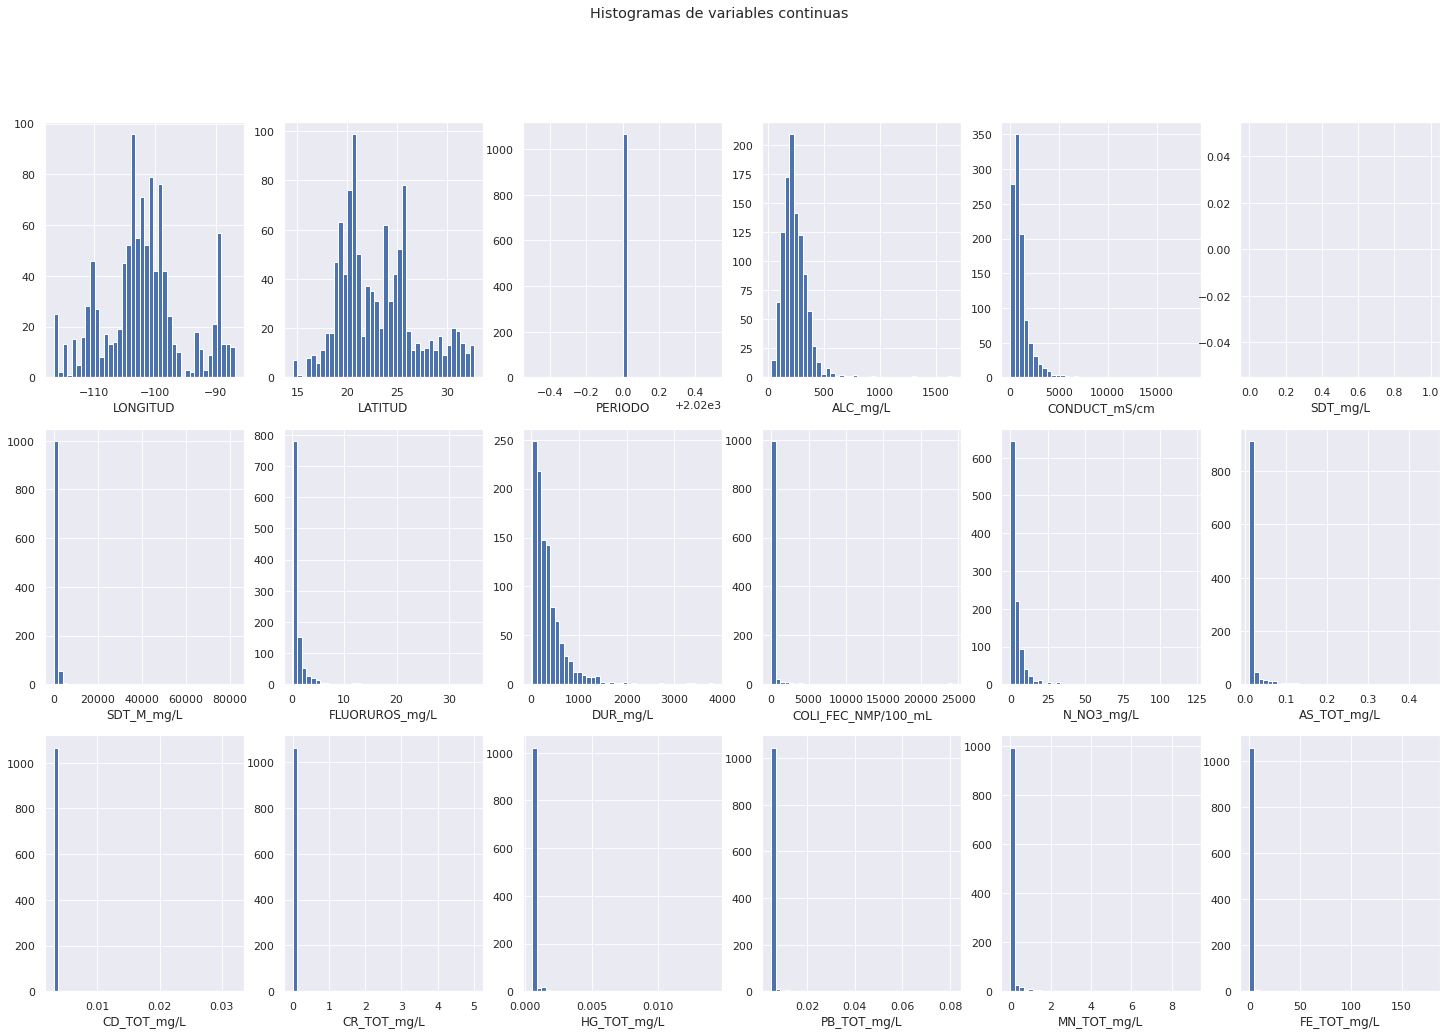

In [ ]:
sns.set(rc={'figure.figsize':(25,16)})
i = 0
fig, axes = plt.subplots(3, 6)    
for col in float_columns:
  plt.subplot(3,6,i+1)    
  plt.hist(df_sub[col].dropna(), bins=40)   
  plt.xlabel(col)
  i+=1

fig.suptitle('Histogramas de variables continuas')
plt.show()

### Boxplots

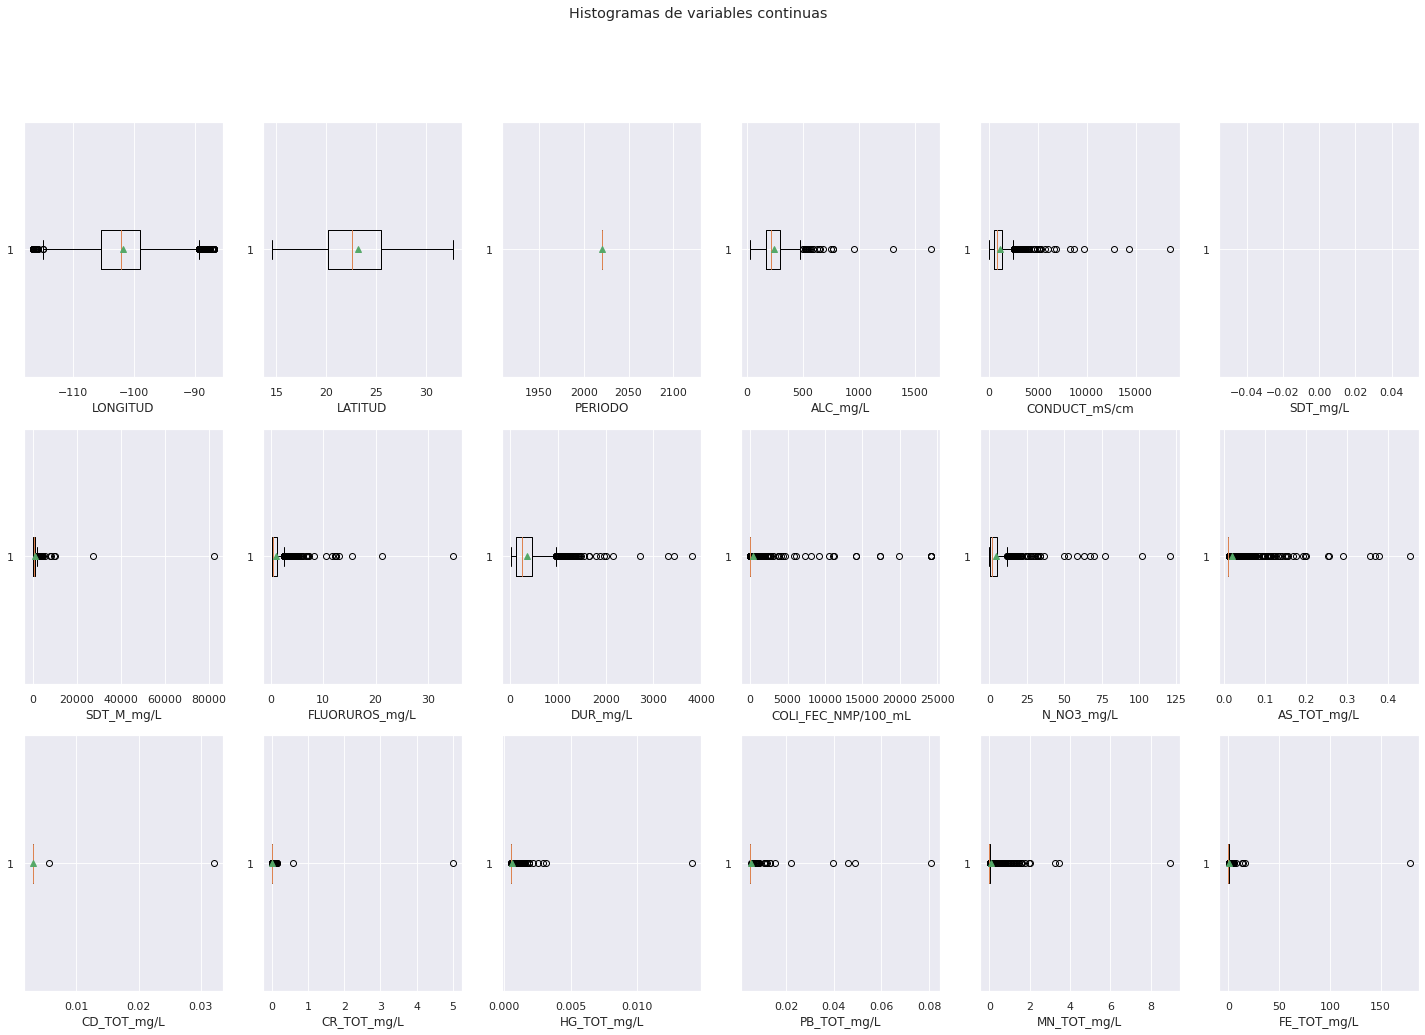

In [ ]:
sns.set(rc={'figure.figsize':(25,16)})
i = 0
fig, axes = plt.subplots(3, 6)    
for col in float_columns:
  plt.subplot(3,6,i+1)    
  plt.boxplot(df_sub[col].dropna(), showmeans=True, vert=False)   
  plt.xlabel(col)
  i+=1

fig.suptitle('Histogramas de variables continuas')
plt.show()

### Boxplots por semaforo

------------------------ 


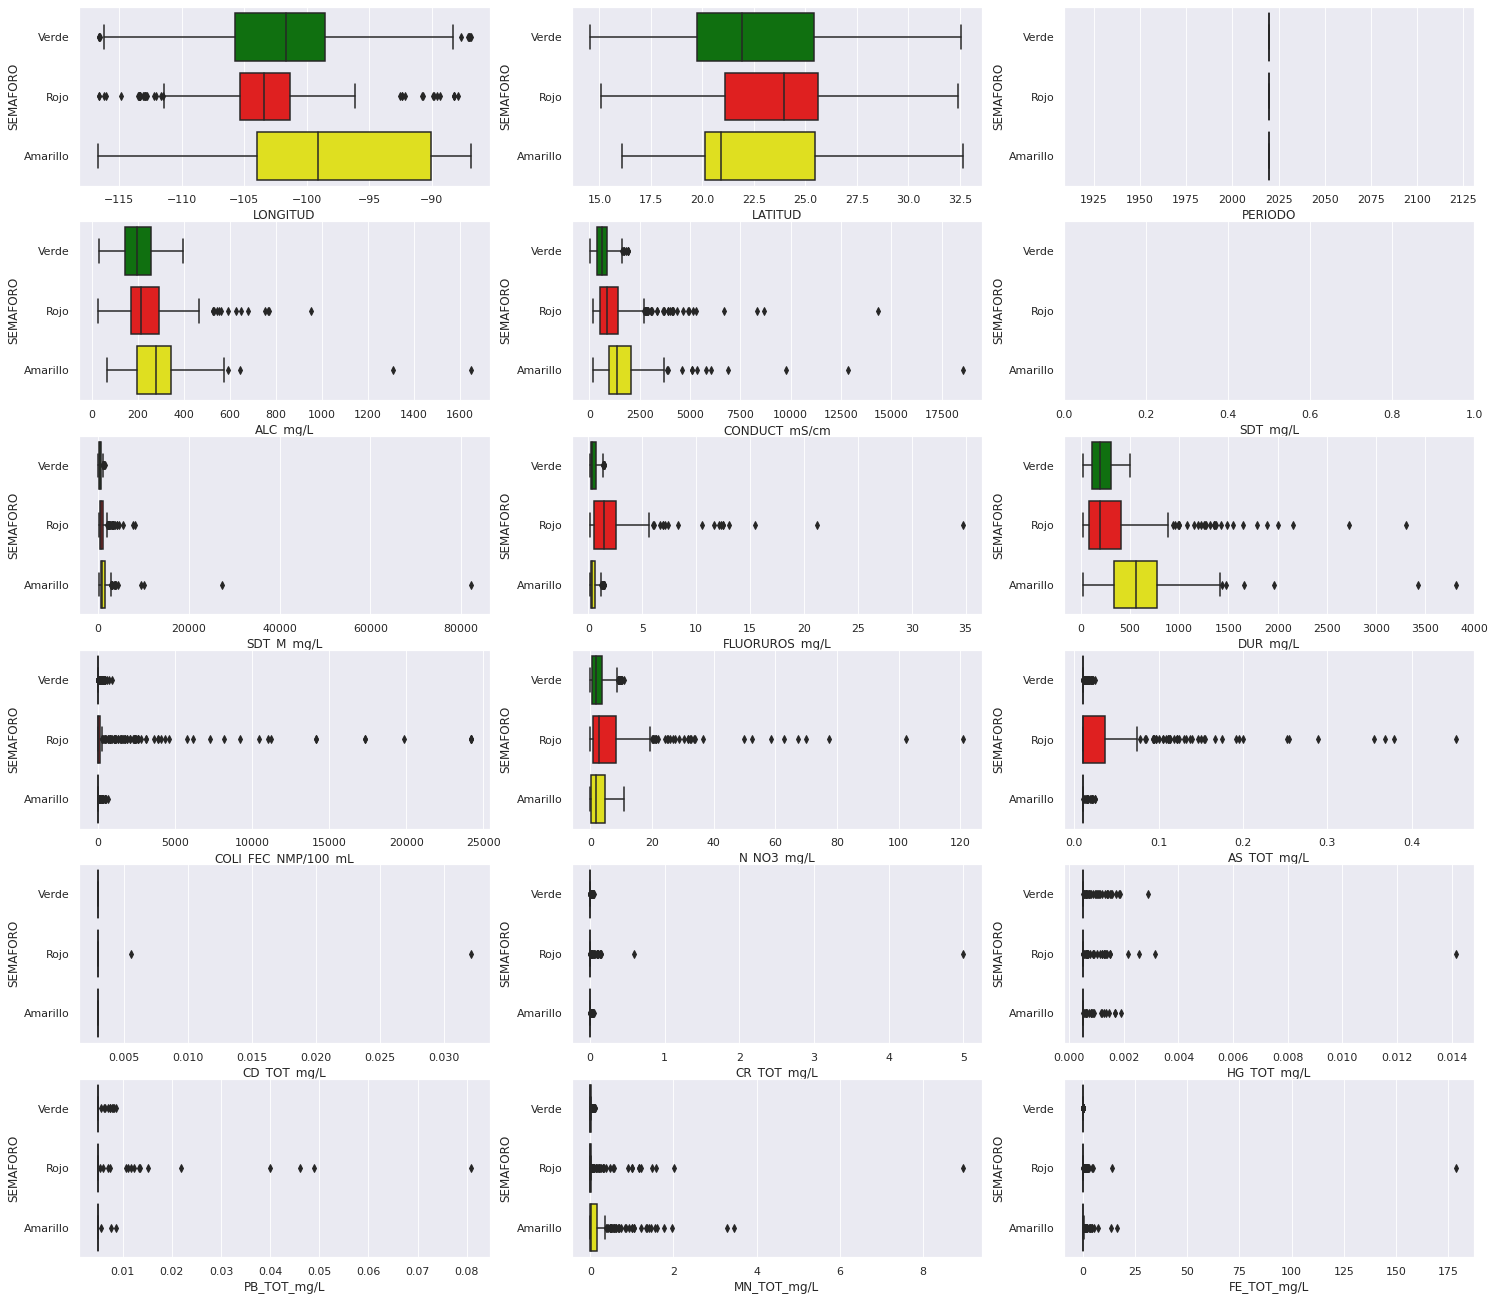

In [ ]:
  sns.set(rc={'figure.figsize':(25,23)})
  fig, axes = plt.subplots(6, 3)    
  i = 0

  for col in float_columns:
    plt.subplot(6,3,i+1) 
    sns.boxplot(y='SEMAFORO',
                x=col,
                data=df_sub,
                orient='horizontal',
                palette=colors_palete)
    plt.xlabel(col)
    i+=1
  print("------------------------ ")

### Correlacion de columnas continuas

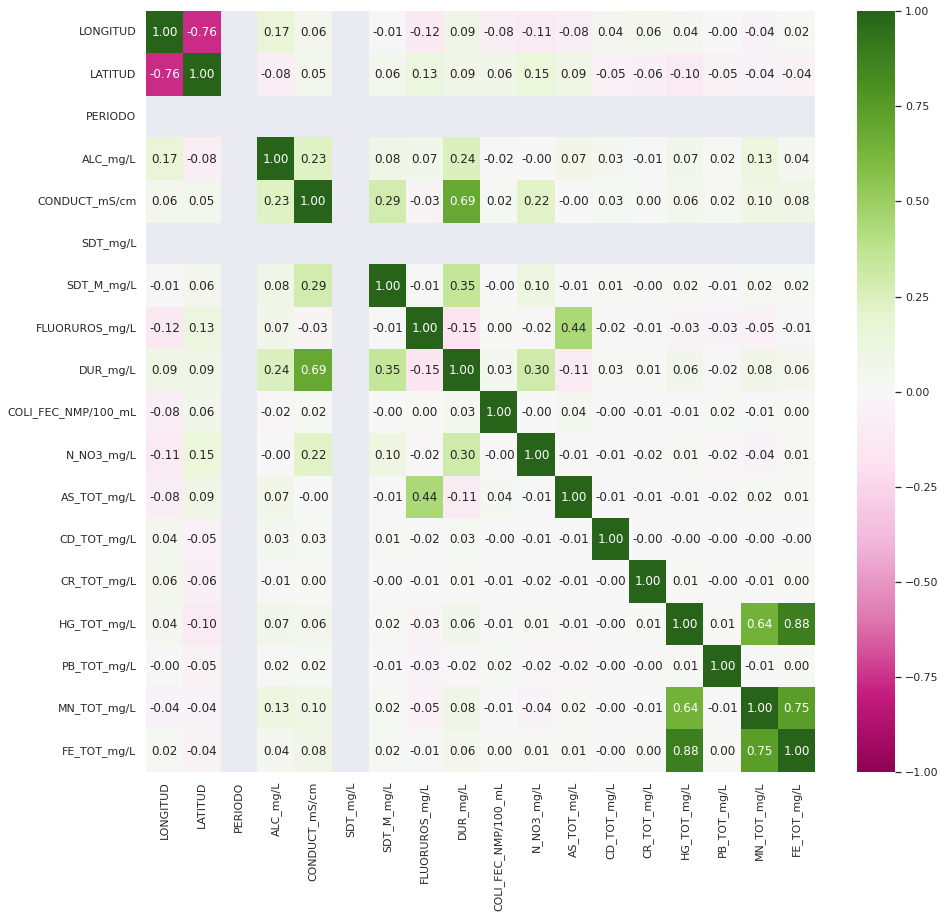

In [ ]:
sns.set(rc={'figure.figsize':(15,14)}) 

sns.heatmap(df_sub.corr(method='pearson'), cmap='PiYG', annot=True, fmt='.2f', vmin=-1, vmax=1)

plt.show()

In [ ]:
categorical_columns = [col for col in df_sub.columns if df_sub[col].dtypes == object][1:]
print(len(categorical_columns), categorical_columns)

38 ['SITIO', 'ORGANISMO_DE_CUENCA', 'ESTADO', 'MUNICIPIO', 'ACUIFERO', 'SUBTIPO', 'CALIDAD_ALC', 'CALIDAD_CONDUC', 'CALIDAD_SDT_ra', 'CALIDAD_SDT_salin', 'CALIDAD_FLUO', 'CALIDAD_DUR', 'CALIDAD_COLI_FEC', 'CALIDAD_N_NO3', 'CALIDAD_AS', 'CALIDAD_CD', 'CALIDAD_CR', 'CALIDAD_HG', 'CALIDAD_PB', 'CALIDAD_MN', 'CALIDAD_FE', 'SEMAFORO', 'CONTAMINANTES', 'CUMPLE_CON_ALC', 'CUMPLE_CON_COND', 'CUMPLE_CON_SDT_ra', 'CUMPLE_CON_SDT_salin', 'CUMPLE_CON_FLUO', 'CUMPLE_CON_DUR', 'CUMPLE_CON_CF', 'CUMPLE_CON_NO3', 'CUMPLE_CON_AS', 'CUMPLE_CON_CD', 'CUMPLE_CON_CR', 'CUMPLE_CON_HG', 'CUMPLE_CON_PB', 'CUMPLE_CON_MN', 'CUMPLE_CON_FE']


## Contaminantes

Conteo de contaminates para cada dato

In [ ]:
for row in df_sub.index:
  try:
    df_sub.at[row,"CONTAMINANTES"] = len(df_sub.loc[row]["CONTAMINANTES"])
  except:
    pass

In [ ]:
df_sub["CONTAMINANTES"]

0       NaN
1       NaN
2         8
3       NaN
4         4
       ... 
1063     14
1064      4
1065     14
1066    NaN
1067    NaN
Name: CONTAMINANTES, Length: 1068, dtype: object

In [ ]:
df_sub['CONTAMINANTES'].fillna(value = 0, inplace=True)

df_sub["CONTAMINANTES"] = df_sub["CONTAMINANTES"].astype(int)

## Contaminantes por semaforo

In [ ]:
df_contamientes = df_sub.groupby(['SEMAFORO'], as_index=False).agg({'CONTAMINANTES':'sum'})
df_contamientes

,SEMAFORO,CONTAMINANTES
0,Amarillo,1969
1,Rojo,3627
2,Verde,0


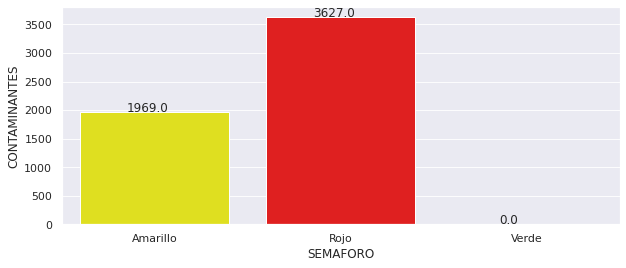

In [ ]:
fig, ax = plt.subplots(figsize=(10,4))

ax = sns.barplot(data=df_contamientes, x='SEMAFORO', y='CONTAMINANTES', palette=['yellow','red', 'green'])

for p in ax.patches:
  ax.annotate(p.get_height(), (p.get_x()+0.25,p.get_height()+5))

plt.show()

## Dataframe acondicionado

In [ ]:
df_sub['SEMAFORO_cat'] = df_sub['SEMAFORO'].replace({'Verde':0,
                                                     'Amarillo':1,
                                                     'Rojo':2})

df_sub['SEMAFORO_cat'] = df_sub['SEMAFORO_cat'].astype(int)

In [ ]:
df_sub_clean = df_sub.drop(['SEMAFORO', 'PERIODO', 'SDT_mg/L'], axis=1)

In [ ]:
df_sub_clean.dtypes

CLAVE                    object
SITIO                    object
ORGANISMO_DE_CUENCA      object
ESTADO                   object
MUNICIPIO                object
ACUIFERO                 object
SUBTIPO                  object
LONGITUD                float64
LATITUD                 float64
ALC_mg/L                float64
CALIDAD_ALC              object
CONDUCT_mS/cm           float64
CALIDAD_CONDUC           object
SDT_M_mg/L              float64
CALIDAD_SDT_ra           object
CALIDAD_SDT_salin        object
FLUORUROS_mg/L          float64
CALIDAD_FLUO             object
DUR_mg/L                float64
CALIDAD_DUR              object
COLI_FEC_NMP/100_mL     float64
CALIDAD_COLI_FEC         object
N_NO3_mg/L              float64
CALIDAD_N_NO3            object
AS_TOT_mg/L             float64
CALIDAD_AS               object
CD_TOT_mg/L             float64
CALIDAD_CD               object
CR_TOT_mg/L             float64
CALIDAD_CR               object
HG_TOT_mg/L             float64
CALIDAD_

In [ ]:
clean_float_columns = [col for col in df_sub_clean.columns if df_sub_clean[col].dtypes != object]
print(len(clean_float_columns), clean_float_columns)

18 ['LONGITUD', 'LATITUD', 'ALC_mg/L', 'CONDUCT_mS/cm', 'SDT_M_mg/L', 'FLUORUROS_mg/L', 'DUR_mg/L', 'COLI_FEC_NMP/100_mL', 'N_NO3_mg/L', 'AS_TOT_mg/L', 'CD_TOT_mg/L', 'CR_TOT_mg/L', 'HG_TOT_mg/L', 'PB_TOT_mg/L', 'MN_TOT_mg/L', 'FE_TOT_mg/L', 'CONTAMINANTES', 'SEMAFORO_cat']


### Visualizacion de dataframe acondicionado

In [ ]:
clean_color_list = ['green','yellow','red']
clean_colors_palete = sns.color_palette(clean_color_list)

------------------------ 


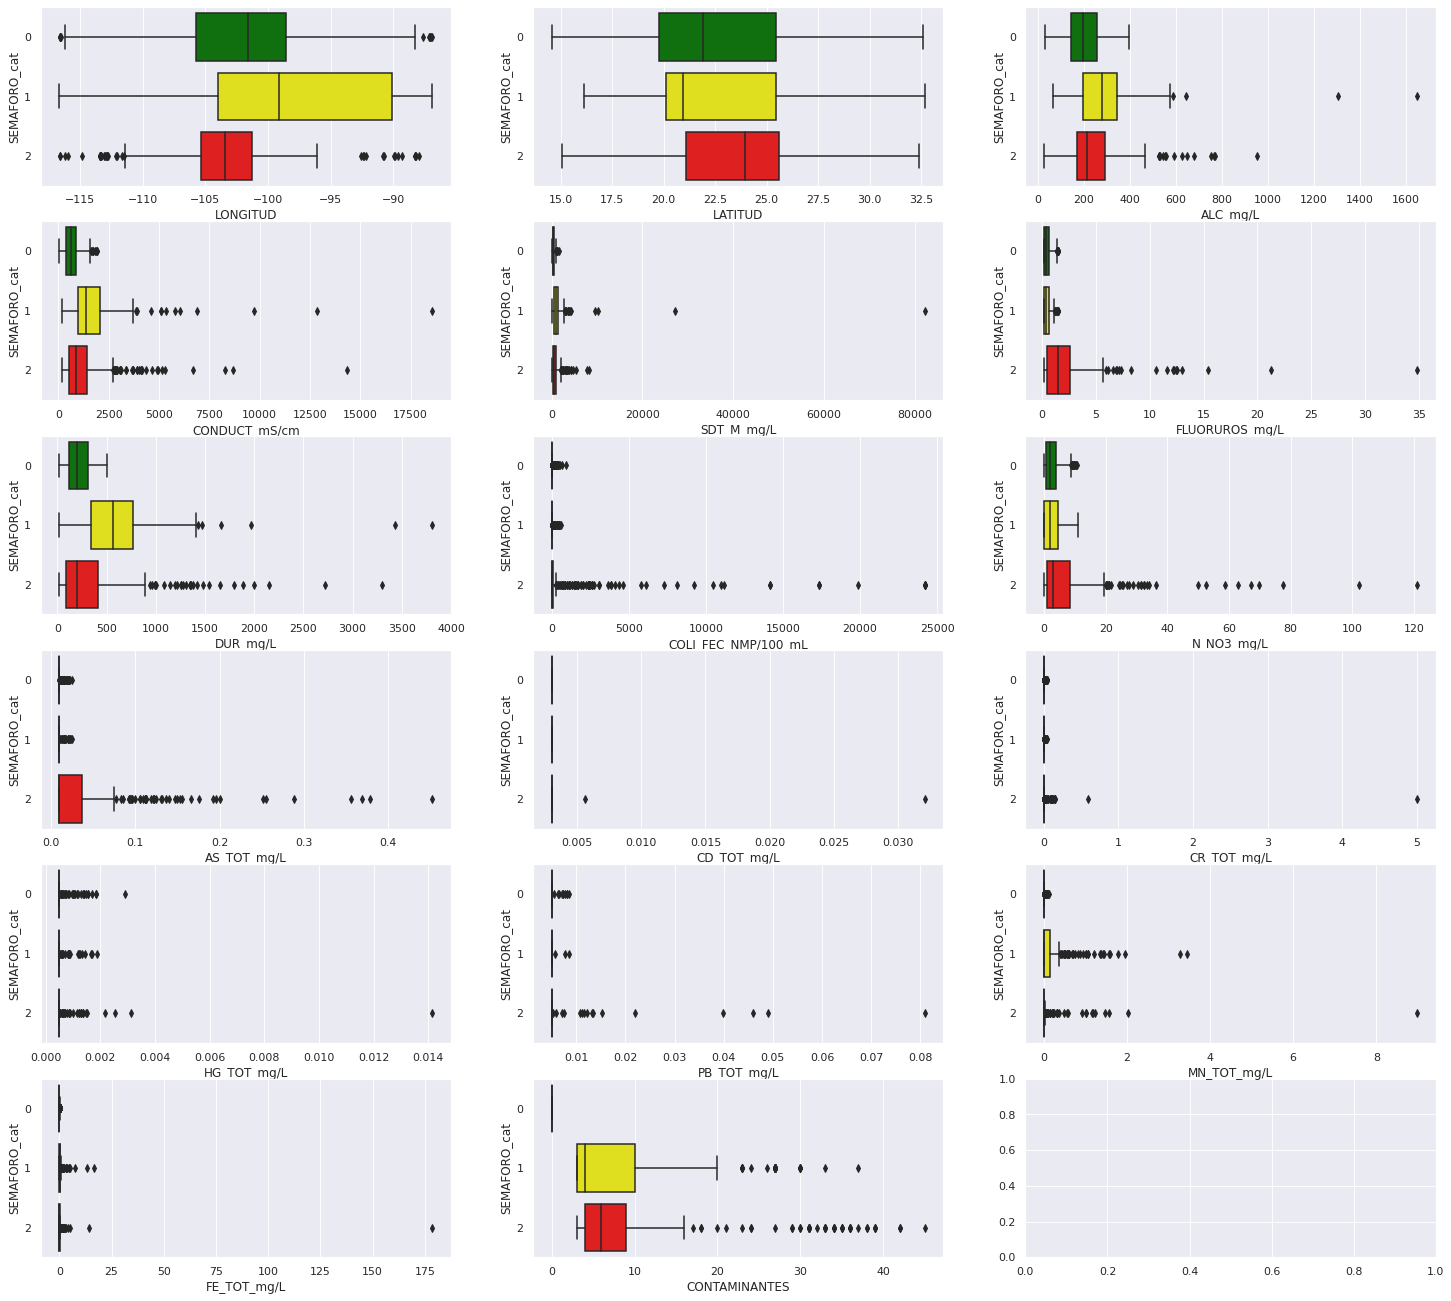

In [ ]:
  sns.set(rc={'figure.figsize':(25,23)})
  fig, axes = plt.subplots(6, 3)    
  i = 0

  for col in clean_float_columns[:-1]:
    plt.subplot(6,3,i+1) 
    sns.boxplot(y='SEMAFORO_cat',
                x=col,
                data=df_sub,
                orient='horizontal',
                palette=clean_colors_palete)
    plt.xlabel(col)
    i+=1
  print("------------------------ ")

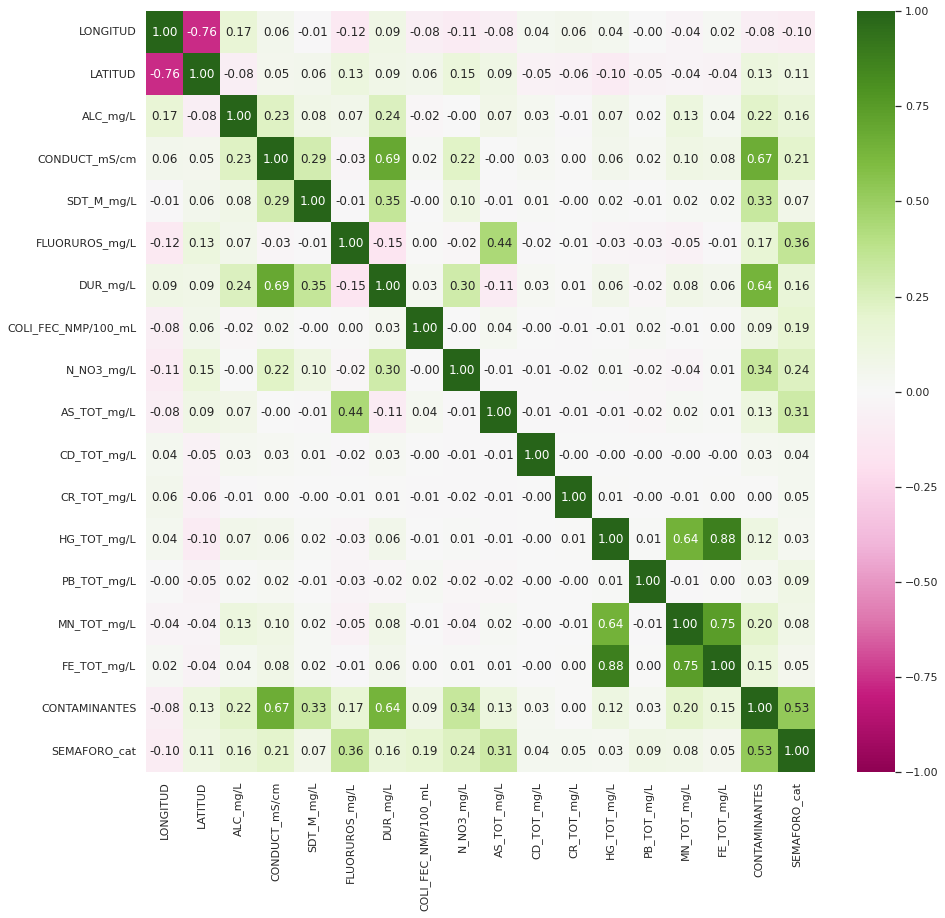

In [ ]:
sns.set(rc={'figure.figsize':(15,14)}) 

sns.heatmap(df_sub_clean.corr(method='pearson'), cmap='PiYG', annot=True, fmt='.2f', vmin=-1, vmax=1)

plt.show()

Existe alta correlacio con la cantidad de contamiantes y el codigo de semaforo

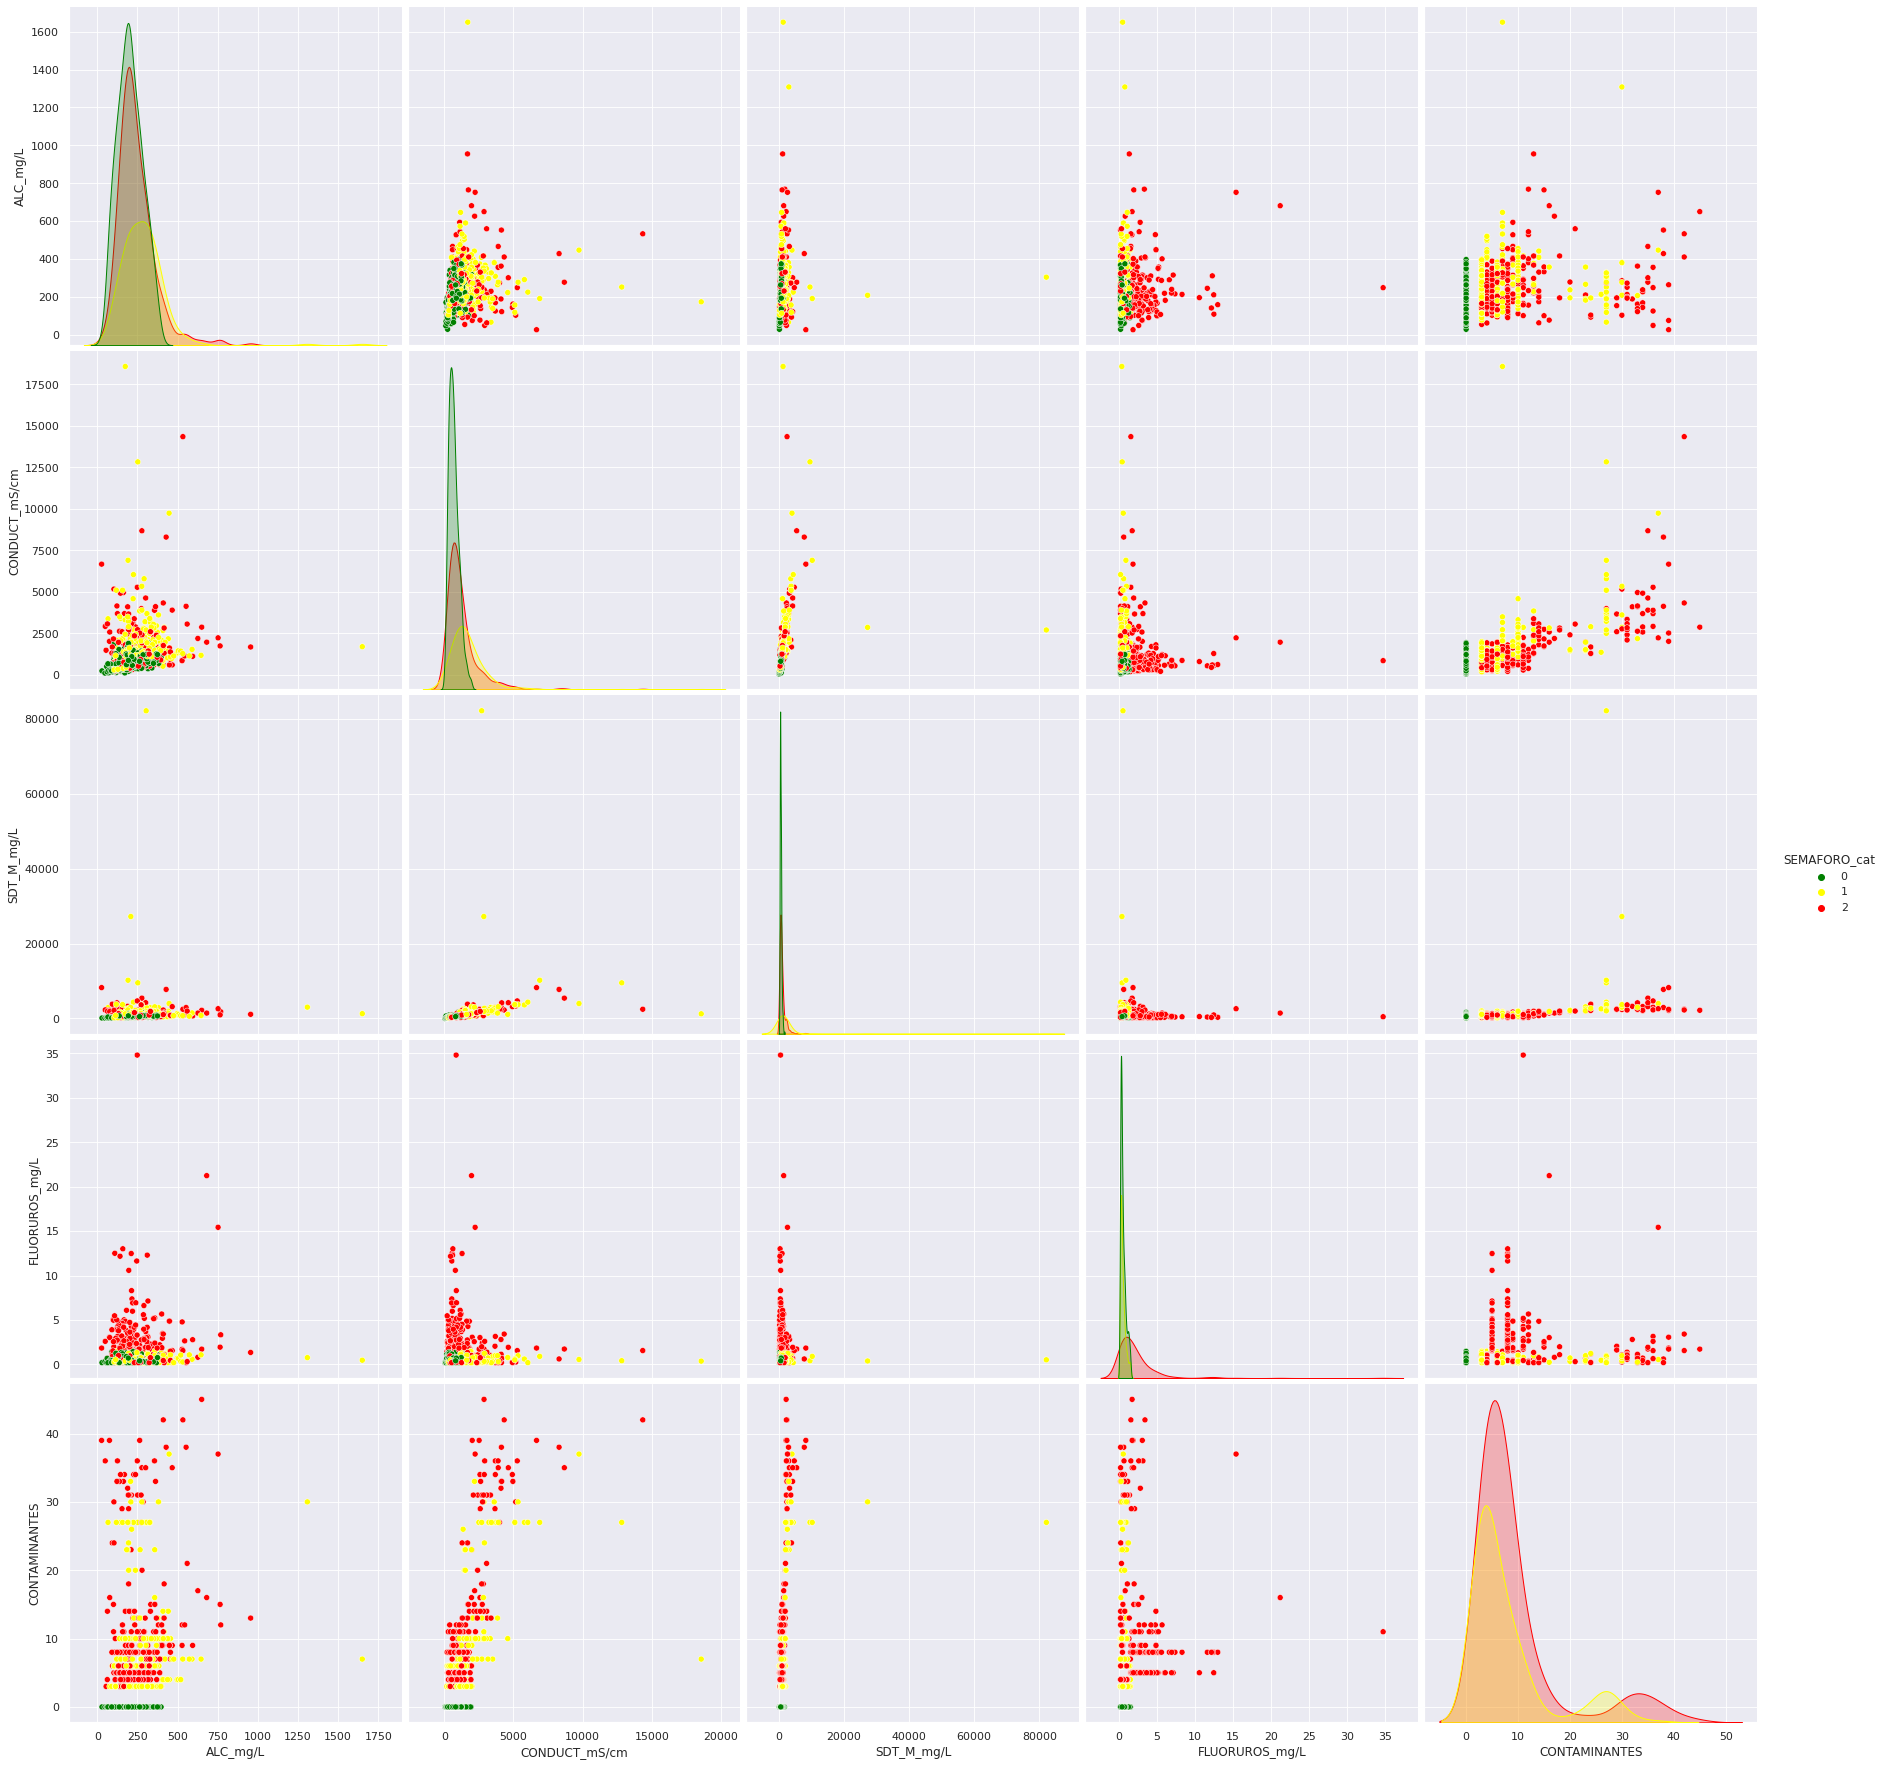

In [ ]:
sns.set(rc={'figure.figsize':(18,12)})
sns.pairplot(df_sub_clean[['ALC_mg/L', 'CONDUCT_mS/cm', 'SDT_M_mg/L', 'FLUORUROS_mg/L', 'CONTAMINANTES','SEMAFORO_cat']], height=5, diag_kind='auto', corner=False, hue='SEMAFORO_cat', palette=clean_colors_palete)

plt.show()

In [ ]:
df_sub_clean["Coordinates"] = list(zip(df_sub_clean.LONGITUD, df_sub_clean.LATITUD))
df_sub_clean["Coordinates"] = df_sub_clean["Coordinates"].apply(Point)

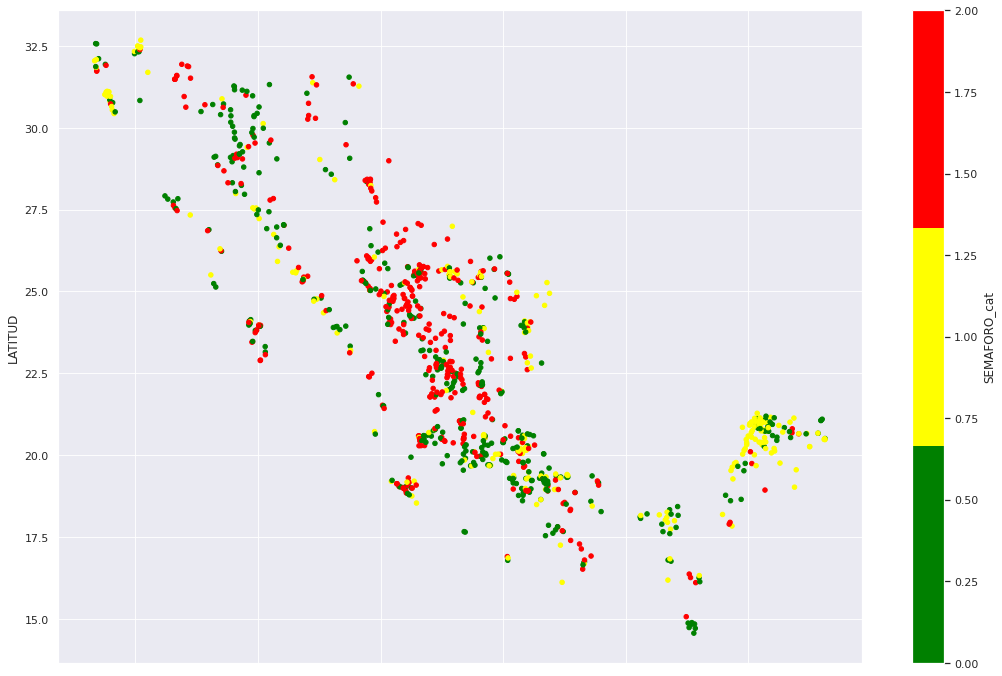

In [ ]:
latlong=df_sub_clean[['LATITUD','LONGITUD', 'SEMAFORO_cat']]

latlong.plot.scatter('LONGITUD','LATITUD', c='SEMAFORO_cat', cmap=ListedColormap(clean_color_list))

plt.show()

In [ ]:
#Poligonos de paises
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
world = world.set_index("iso_a3")

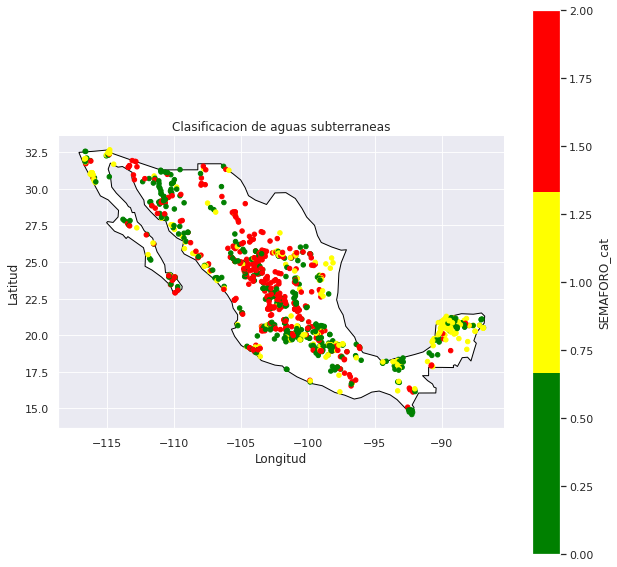

In [ ]:
fig, gax = plt.subplots(figsize=(10,10))

world.query("name == 'Mexico'").plot(ax = gax, edgecolor='black', color='white')

latlong.plot.scatter('LONGITUD','LATITUD', c='SEMAFORO_cat', cmap=ListedColormap(clean_color_list), ax=gax)

gax.set_xlabel('Longitud')
gax.set_ylabel('Latitud')
gax.set_title('Clasificacion de aguas subterraneas')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()

In [ ]:
df_sub_clean.head()

,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,ACUIFERO,SUBTIPO,LONGITUD,LATITUD,ALC_mg/L,...,CUMPLE_CON_NO3,CUMPLE_CON_AS,CUMPLE_CON_CD,CUMPLE_CON_CR,CUMPLE_CON_HG,CUMPLE_CON_PB,CUMPLE_CON_MN,CUMPLE_CON_FE,SEMAFORO_cat,Coordinates
0,DLAGU6,POZO SAN GIL,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,ASIENTOS,VALLE DE CHICALOTE,POZO,-102.02210,22.20887,229.990,...,SI,SI,SI,SI,SI,SI,SI,SI,0,POINT (-102.0221 22.20887)
1,DLAGU6516,POZO R013 CAÑADA HONDA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,AGUASCALIENTES,VALLE DE CHICALOTE,POZO,-102.20075,21.99958,231.990,...,SI,SI,SI,SI,SI,SI,SI,SI,0,POINT (-102.20075 21.99958)
2,DLAGU7,POZO COSIO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,COSIO,VALLE DE AGUASCALIENTES,POZO,-102.28801,22.36685,204.920,...,SI,NO,SI,SI,SI,SI,SI,SI,2,POINT (-102.28801 22.36685)
3,DLAGU9,POZO EL SALITRILLO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,VALLE DE AGUASCALIENTES,POZO,-102.29449,22.18435,327.000,...,SI,SI,SI,SI,SI,SI,SI,SI,0,POINT (-102.29449 22.18435)
4,DLBAJ107,RANCHO EL TECOLOTE,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LA PAZ,TODOS SANTOS,POZO,-110.24480,23.45138,309.885,...,NO,SI,SI,SI,SI,SI,SI,SI,2,POINT (-110.2448 23.45138)


#Kmeans

In [ ]:
from sklearn.cluster import KMeans

In [ ]:
k = 31
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(df_sub_clean[['LONGITUD','LATITUD','SEMAFORO_cat']])

In [ ]:
mkr_dict = {0: 'o', 1: '+', 2: 'x'}

df_sub_clean['kmean_group'] = y_pred
latlong = df_sub_clean[['LATITUD','LONGITUD', 'SEMAFORO_cat','kmean_group']]

latlong['marker'] = latlong['SEMAFORO_cat'].replace(mkr_dict)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


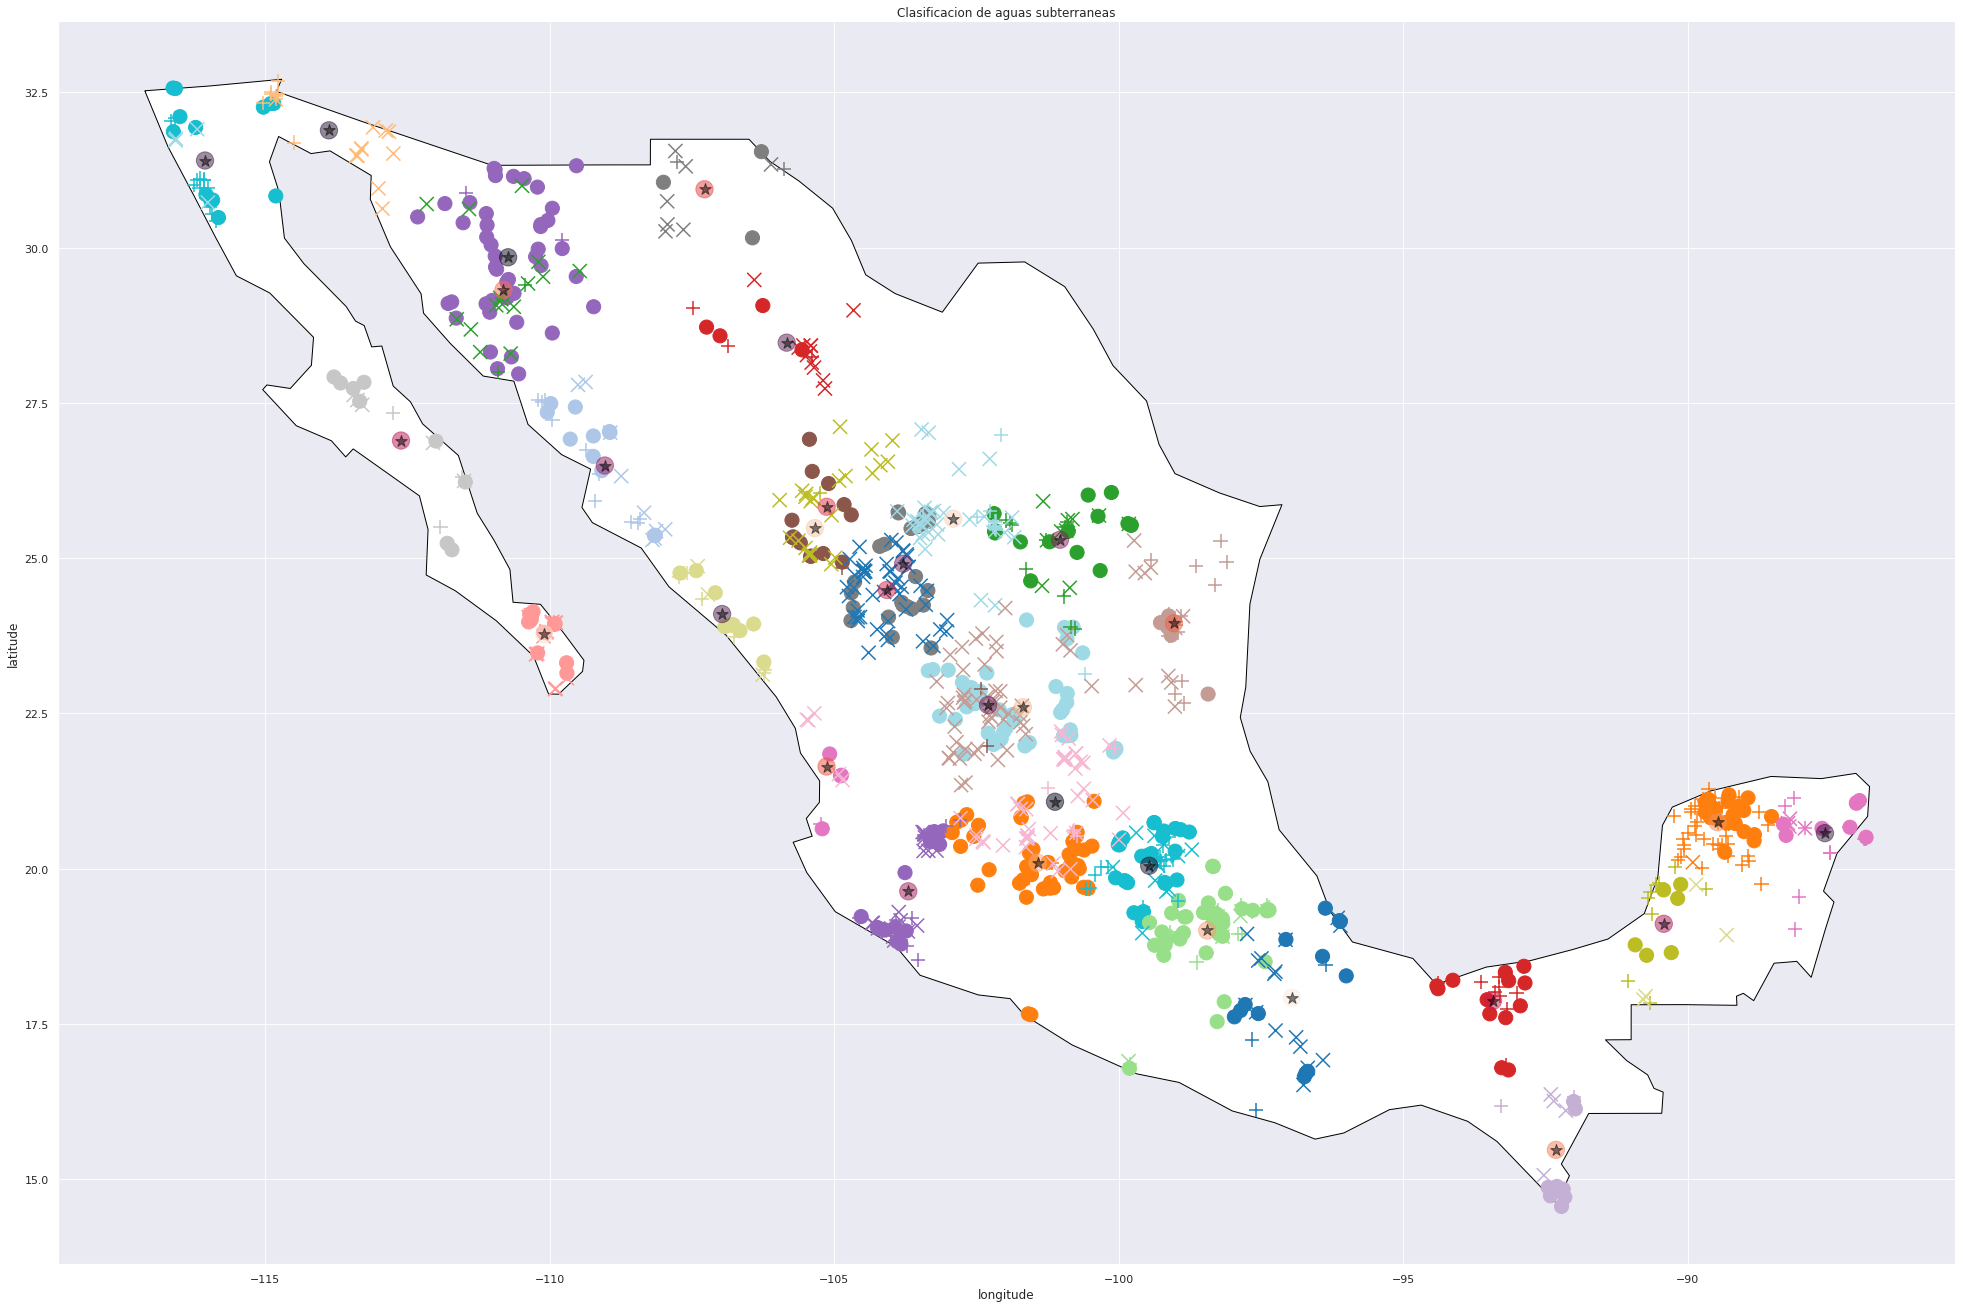

In [ ]:
fig, gax = plt.subplots(figsize=(34,34))

world.query("name == 'Mexico'").plot(ax = gax, edgecolor='black', color='white')



for sem, mkr in mkr_dict.items():
  d = latlong[latlong.SEMAFORO_cat==sem]
  gax.scatter(x=d.LONGITUD, y=d.LATITUD, marker=mkr, c=d.kmean_group, cmap='tab20', s=200)
#latlong.plot.scatter('LONGITUD','LATITUD', c='kmean_group', cmap='tab20',  ax=gax, legend=None, s=50)

gax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c=pd.DataFrame(y_pred)[0].unique(), marker='o', s=300, alpha=0.5)
gax.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='black', marker='*', s=150, alpha=0.5)

gax.set_xlabel('longitude')
gax.set_ylabel('latitude')
gax.set_title('Clasificacion de aguas subterraneas')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)

plt.show()